### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

Text(-45, 55, 'NAH')

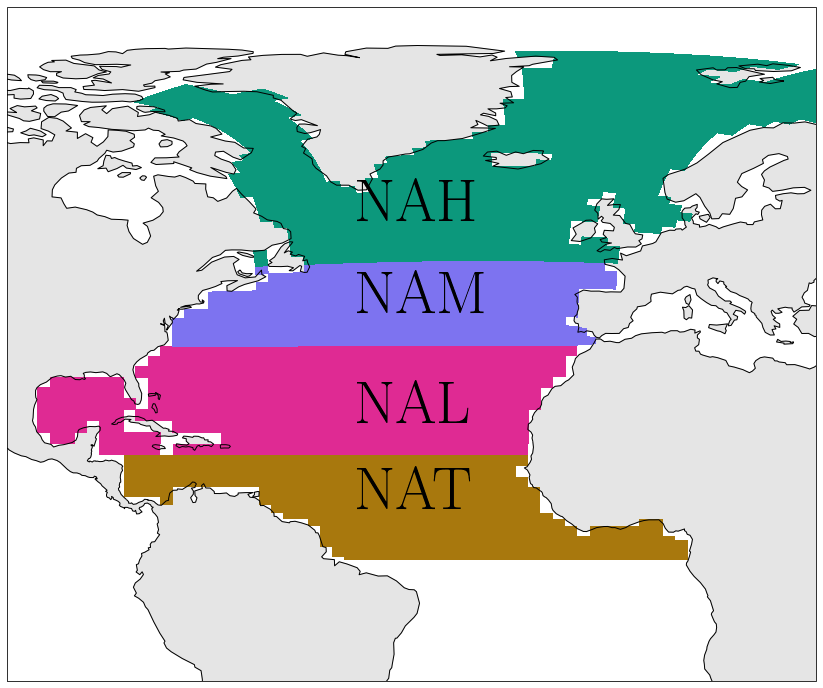

In [4]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

    
regs = ['NAT', 'NAL', 'NAM', 'NAH']#, 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'NAT' : {'number' : 1},
           'NAL' : {'number': 2},
          'NAM' : {'number': 3},
           'NAH' : {'number': 4},
           
          }

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[atl[regs[i]][0,0,:,:] == 1] = regdict[regs[i]]['number']
maskno[maskno == 0] = np.nan

fact = 1
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())

year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
mesh = ax.pcolormesh(nav_lon, nav_lat, maskno, transform=ccrs.PlateCarree(), cmap=cm.phase, zorder =0, alpha = 1,\
                    vmin = 1, vmax = 5)

ax.coastlines(zorder = 1 )
#lons, lats extent
ax.set_extent([ -102, 30, -20, 120,], crs=ccrs.PlateCarree())

ax.add_feature(cp.feature.LAND, color='grey', alpha = 0.2)
fs = 60
ax.text(-45, 8, s = f'NAT', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 22, s = f'NAL', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 40, s = f'NAM', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 55, s = f'NAH', color='k', \
        fontsize = fs, fontweight = 'bold', transform=ccrs.Geodetic())

## area-weighted province maps

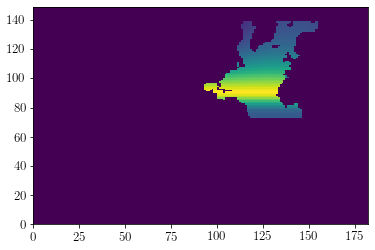

In [5]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

(atl)

area_broad = np.zeros([1,31,149,182])

for i in range(0,31):
    
    area_broad[0,i,:,:] = atl.tmask[0,i,:,:]*atl.e1t[0,:,:]*atl.e2t[0,:,:]

atl['NAT_area'] = atl.NAT * area_broad
atl['NAL_area'] = atl.NAL * area_broad
atl['NAM_area'] = atl.NAM * area_broad
atl['NAH_area'] = atl.NAH * area_broad
atl['ATL_area'] = atl.ATL * area_broad

plt.figure()
plt.pcolormesh(atl.ATL_area[0,0,:,:])

atl = atl.rename({'z': 'deptht'})

## get a depth profile of all species in atl and plot, for all 4 seasons
save first as netcdf

put this in extract_dp.py


In [6]:
def make_yearlist(yrst, yrend, typ = 'PPINT'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    
    for yr in (yrs):
        tyr = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_{typ}_T.nc')
        ylist.append(tyr)
        
    return ylist

## one decade

In [7]:
ex = False

yrst = 1950; yrend = 1959

if ex:
    
    ylist = make_yearlist(yrst, yrend)
    ppint = xr.open_mfdataset(ylist)
    ylist = make_yearlist(yrst, yrend, typ = 'diad')
    diad = xr.open_mfdataset(ylist)
    ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
    ptrc = xr.open_mfdataset(ylist)

    msks = ['ATL', 'NAT','NAL','NAM','NAH']
    tdats = [ptrc, diad, ppint]
    tdatns = ['ptrc', 'diad', 'ppint']
    for i in range(2,3):
        tdat = tdats[i]
        tdatn = tdatns[i]
        for mask in msks:
            tdatnam = f'{tdatn}_'
            masknam = f'{mask}_area'
            savenam = f'./data/{tdatnam}{yrst}-{yrend}-{mask}.nc'
            
            print(savenam)
            ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
            weighted(atl[mask]).mean(dim = ['x','y'])
            ds.to_netcdf(savenam)

In [8]:
ex = False

yrst = 1951; yrend = 2023

if ex:
    
    for yr in (yrst,yrend):
        try:
            yrst = yr; yrend = yr

            ylist = make_yearlist(yrst, yrend)
            ppint = xr.open_mfdataset(ylist)
            ylist = make_yearlist(yrst, yrend, typ = 'diad')
            diad = xr.open_mfdataset(ylist)
            ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
            ptrc = xr.open_mfdataset(ylist)

            msks = ['ATL', 'NAT','NAL','NAM','NAH']
            tdats = [ptrc, diad, ppint]
            # tdatns = ['ptrc', 'diad', 'ppint']
            # for i in range(0,1):
            #     tdat = tdats[i]
            #     tdatn = tdatns[i]
            for mask in msks:
                tdatn = 'ptrc'; tdat = ptrc
                q = ['O2','PIIC','DOC','CaCO3','ARA','POC','GOC','BSi','GON']
                tdat = tdat.drop_vars(q)
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])
                ds.to_netcdf(savenam)
                #print(ds)

                tdatn = 'diad'; tdat = diad
                #print(list(tdat.variables))
                q2 = [
                 'time_counter_bounds','CARBTRP','CAPITRP','ALKTRP','GRAMIC',
                 'GRAMES','GRAMAC','PPTDOC','Detrit','Carniv',
                 'Herbiv','GRAMICPHY','GRAPTEPHY','GRAMESPHY','GRAGELPHY',
                 'GRAMACPHY','nitrfix','denitr','DELO2','vsink','sinksil','discarb','ExpCO3','ExpARA',
                 'GRAGEL','GRAPTE','proara','prococ','lim2mmfe_dia','lim2mmfe_mix','lim2mmfe_coc','lim2mmfe_pic',
                 'lim2mmfe_pha','lim2mmfe_fix','PICflx','Oflx',]
                tdat = tdat.drop_vars(q2)
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])            
                ds.to_netcdf(savenam)

                tdatn = 'ppint'; tdat = ppint
                tdatnam = f'{tdatn}_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.groupby('time_counter.season').mean(dim = ['time_counter']).\
                weighted(atl[masknam]).mean(dim = ['x','y'])            
                ds.to_netcdf(savenam)
        except:
            print(f'yr {yr} problem')

## plotting code

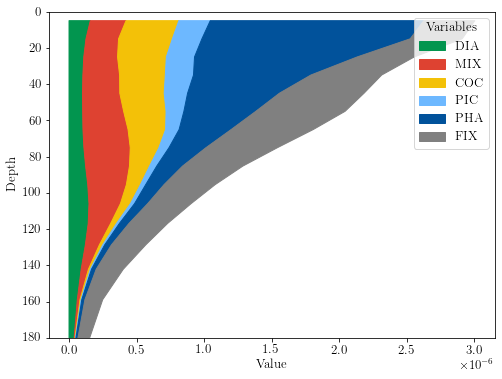

In [9]:
ds = xr.open_dataset('./data/ptrc_1950-ATL.nc')
metro = ['#02954f', '#de4231','#f3c108','#6db8ff','#01529b','grey']

tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

fig, ax = plt.subplots(figsize=(8, 6))

# Track the cumulative sum to create stacking effect
cumulative = np.zeros_like(ds.deptht.values)
# Plot each variable
ind = 0
for var in tvars:
    # Get the data for the variable
    values = np.squeeze(ds[var].sel(season = ds.season == 'JJA').sel(t = 0).values)
    
    # Calculate the new cumulative total
    new_cumulative = cumulative + values
    # print(cumulative)
    # print(new_cumulative)
    # Use fill_betweenx to create the stacked profile
    ax.fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                     label=var, color = metro[ind])
    
    # Update cumulative for the next stack
    cumulative = new_cumulative
    ind = ind+1

# Invert y-axis if depth is positive going downward
ax.set_ylim([0,180])
#ax.set_xlim([0,1e-13])
ax.invert_yaxis()


# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Depth')
ax.legend(title='Variables')
plt.show()

In [10]:
# for yr in range(1950,2023):
#     try:
#         w = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_PPINT_T.nc')
#     except:
#         print(yr)


In [11]:

# fact = 1.1
# fig, axs = plt.subplots(5,4, figsize=(12*fact, 16*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()
# regs = ['ATL', 'NAT', 'NAL', 'NAM', 'NAH']
# seas = ['DJF','MAM','JJA','SON']
# ind = 0
# for i in range(0,5):
#     for d in range(0,4):
        
#         ds = xr.open_dataset(f'./data/ppint_1950-{regs[i]}.nc')
        
#         axs[ind].set_title(f'{regs[i]} {seas[d]}')
        
#         cumulative = np.zeros_like(ds.deptht.values)
    
#         mv = 0
#         for var in tvars:
#             # Get the data for the variable
#             vara = var.lower()
#             tseas = seas[d]
#             values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

#             # Calculate the new cumulative total
#             new_cumulative = cumulative + values
#             # Use fill_betweenx to create the stacked profile
#             axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
#                              label=var, color = metro[mv])
#             mv=mv+1
#             # Update cumulative for the next stack
#             cumulative = new_cumulative
        
#         axs[ind].set_ylim([0,180])
#         axs[ind].set_xlim([0,1.5e-8])
#         axs[ind].invert_yaxis()
#         ind = ind+1

#         # Invert y-axis if depth is positive going downward



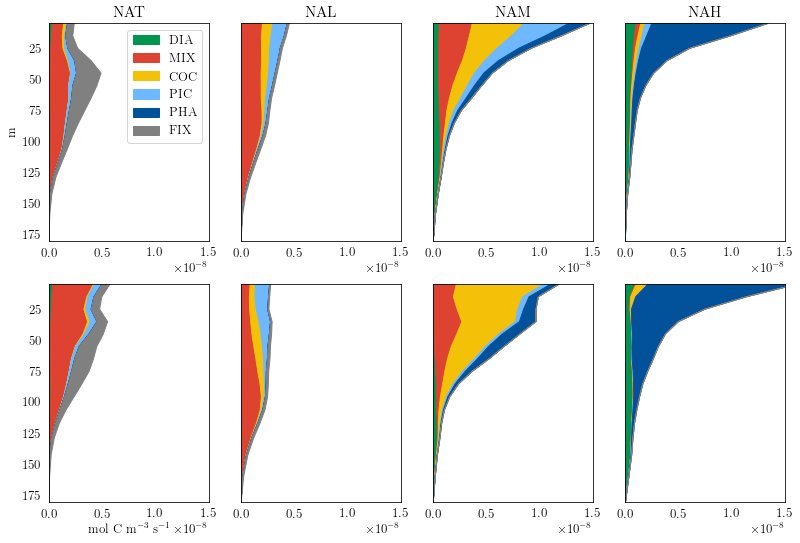

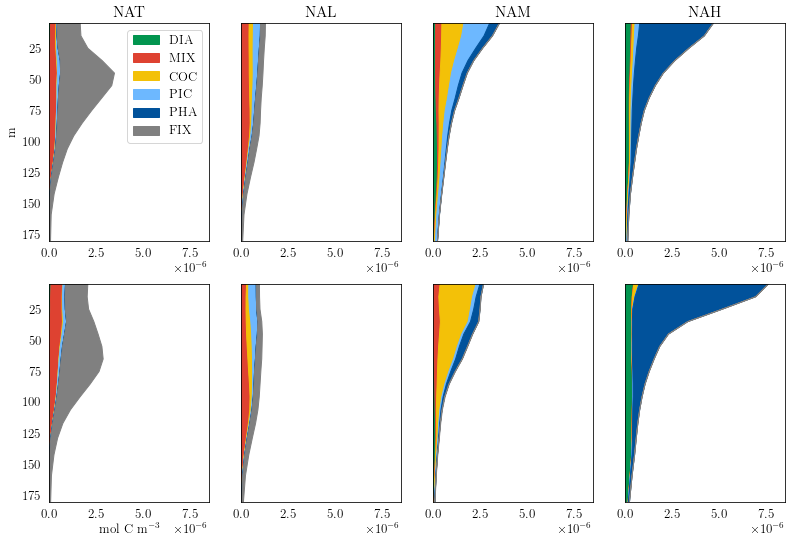

In [12]:
fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
regs = ['NAT', 'NAL', 'NAM', 'NAH']
seas = ['MAM','JJA']
ind = 0
for d in range(0,2):
    for i in range(0,4):

        ds = xr.open_dataset(f'./data/ppint_1956-{regs[i]}.nc')
        
        if ind < 4:
            axs[ind].set_title(f'{regs[i]}')
        
        cumulative = np.zeros_like(ds.deptht.values)
    
        mv = 0
        for var in tvars:
            # Get the data for the variable
            vara = var.lower()
            tseas = seas[d]
            values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

            # Calculate the new cumulative total
            new_cumulative = cumulative + values
            # Use fill_betweenx to create the stacked profile
            axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                             label=var, color = metro[mv])
            mv=mv+1
            # Update cumulative for the next stack
            cumulative = new_cumulative
        
        axs[ind].set_ylim([5,180])
        axs[ind].set_xlim([0,1.5e-8])
        axs[ind].invert_yaxis()
        axs[ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[ind].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        ind = ind+1
        axs[0].legend(loc = 'best')
        axs[0].set_ylabel('m')
        axs[4].set_xlabel('mol C m$^{-3}$ s$^{-1}$')

        # Invert y-axis if depth is positive going downward


### 
fact = 1.1
fig, axs = plt.subplots(2,4, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
regs = ['NAT', 'NAL', 'NAM', 'NAH']
seas = ['MAM','JJA']
ind = 0
for d in range(0,2):
    for i in range(0,4):

        ds = xr.open_dataset(f'./data/ptrc_1956-{regs[i]}.nc')
        
        if ind < 4:
            axs[ind].set_title(f'{regs[i]}')
        
        cumulative = np.zeros_like(ds.deptht.values)
    
        mv = 0
        for var in tvars:
            # Get the data for the variable
            vara = var#.lower()
            tseas = seas[d]
            values = np.squeeze(ds[vara].sel(season = ds.season == tseas).sel(t = 0).values)

            # Calculate the new cumulative total
            new_cumulative = cumulative + values
            # Use fill_betweenx to create the stacked profile
            axs[ind].fill_betweenx(ds.deptht.values, cumulative, new_cumulative,\
                             label=var, color = metro[mv])
            mv=mv+1
            # Update cumulative for the next stack
            cumulative = new_cumulative
        
        axs[ind].set_ylim([5,180])
        axs[ind].set_xlim([0,8.5e-6])
        axs[ind].invert_yaxis()
        axs[ind].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[ind].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        ind = ind+1
        axs[0].legend(loc = 'best')
        axs[0].set_ylabel('m')
        axs[4].set_xlabel('mol C m$^{-3}$')

        # Invert y-axis if depth is positive going downward



Text(0.5, 1.0, 'SPRING     SUMMER')

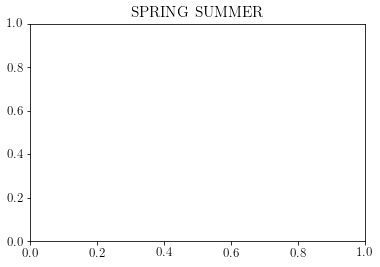

In [13]:
plt.figure()
plt.title('SPRING     SUMMER')

## who is limiting

In [14]:
        # A = f'lim3fe_{pft}'
        # B = f'lim4po4_{pft}'
        # if pft == 'dia':
        #     C = f'lim5si_{pft}'
        # D = f'lim6din_{pft}'

In [15]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_LC02//ORCA2_1m_19560101_19561231_LoP_T.nc')
tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

q = w['LN_dia'].values
print(np.shape(q))

per = np.zeros([6,4,12])

for v in range(0,6):
    
    tvar = tvars[v].lower()
    tvar2 = f'LN_{tvar}'
    print(tvar2)
    for p in range(3,7):

        for i in range(0,12):

            
            test = w[tvar2][i,0:11,:,:].values
            test2 = np.zeros_like(test)
            test2[test == p] = 1

            per[v,p-3,i] = np.nansum(test2*atl.ATL_area[0,0:11,:,:])/np.nansum(atl.ATL_area[0,0:11,:,:])
    # * atl.ATL_area.values
    #test = np.nansum
percs = (np.nanmean(per, axis = 2))

(12, 31, 149, 182)
LN_dia
LN_mix
LN_coc
LN_pic
LN_pha
LN_fix


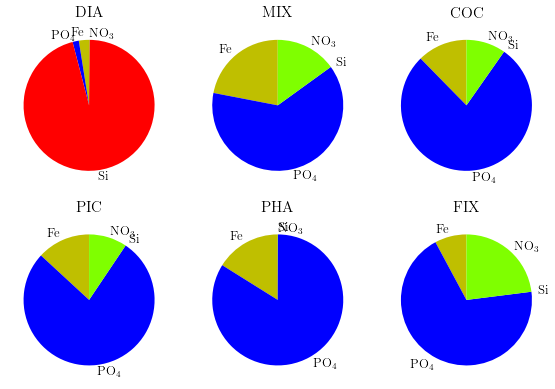

In [16]:
import matplotlib.pyplot as plt

# Data for the pie chart
# Hex code for mauve is #E0B0FF

# Creating the pie chart

tvars = ['DIA','MIX','COC','PIC','PHA','FIX']

fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), \
                        facecolor='w', edgecolor='k', sharex = True, sharey = True)
axs = axs.ravel()
for i in range(0,6):
    
    values = percs[i,:]
    labels = ['Fe', 'PO$_4$', 'Si', 'NO$_3$']

    # Colors for the chart, replacing 'mauve' with its hex code approximation
    colors = ['y', 'b', 'r', 'chartreuse']  
    axs[i].pie(values, labels=labels, colors=colors, startangle=90)
    axs[i].set_title(tvars[i])
    # plt.title('Pie Chart with Custom Colors')
    # plt.show()
    plt.tight_layout()

In [17]:
# def make_yearlist(yrst, yrend, typ = 'PPINT'):
#     yrs = np.arange(yrst,yrend+1,1)
#     ylist = []
    
#     for yr in (yrs):
#         tyr = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_{typ}_T.nc')
#         ylist.append(tyr)
        
#     return ylist
# ylist = xr.open_mfdataset(make_yearlist(yrst, yrend, typ = 'LoP'))

# np.nanmin(ylist.LV_dia.values)

In [23]:
ex = False

def make_yearlist(yrst, yrend, typ = 'PPINT'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    
    for yr in (yrs):
        tyr = glob.glob(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_LA02//ORCA2_1m_{yr}0101_{yr}1231_{typ}_T.nc')
        ylist.append(tyr)
        
    return ylist

yrst = 1950; yrend = 1960

if ex:
    
    for yr in range(yrst,yrend):
        try:
            yrst = yr; yrend = yr

            ylist = make_yearlist(yrst, yrend, typ = 'LoP')
            LoP = xr.open_mfdataset(ylist)
            # ylist = make_yearlist(yrst, yrend, typ = 'ptrc')
            # ptrc = xr.open_mfdataset(ylist)

            msks = ['ATL', 'NAT','NAL','NAM','NAH']
            #tdats = [ptrc, diad, ppint]
            # tdatns = ['ptrc', 'diad', 'ppint']
            # for i in range(0,1):
            #     tdat = tdats[i]
            #     tdatn = tdatns[i]
            for mask in msks:
                tdatn = 'LoP'; tdat = LoP
                q = ['LN_dia','LN_mix','LN_coc','LN_pic','LN_pha','LN_fix',]
                tdat = tdat.drop_vars(q)
                tdat = tdat.map(lambda x: x.where(~np.isinf(x), 1))
                tdatnam = f'{tdatn}_fy_'; masknam = f'{mask}_area'
                savenam = f'./data/{tdatnam}{yrst}-{mask}.nc'
                print(savenam)
                ds = tdat.weighted(atl[masknam]).mean(dim = ['x','y'])
                ds.to_netcdf(savenam)
                #print(ds)


        except:
            print(f'yr {yr} problem')

In [24]:
# ds.LV_dia[:,0,0].values

In [25]:
w = xr.open_dataset('./data/LoP_fy_1959-NAH.nc')
w.LV_dia[:,0,0]

<xarray.DataArray 'LV_dia' (time_counter: 12)>
array([0.485153, 0.518425, 0.526288, 0.457015, 0.356613, 0.265185, 0.218539,
       0.212012, 0.244756, 0.285915, 0.337325, 0.41308 ])
Coordinates:
    deptht         float32 5.0
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1959-01-16 12:00:00 ... 1959-12-16 1...

In [27]:
def make_yearlist(yrst, yrend, mask):
    
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data/LoP_fy_{yrs[i]}-{mask}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])

    return ylist


NAT = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAT'))
NAL = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAL'))
NAM = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAM'))
NAH = xr.open_mfdataset(make_yearlist(1950, 1959, 'NAH'))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


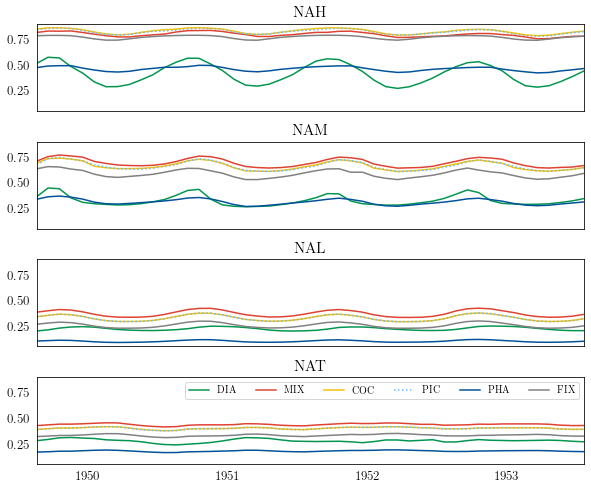

In [45]:
regs = [ 'NAH','NAM','NAL','NAT', ]
fact = 0.7

va = ['LV_dia',
 'LV_mix',
 'LV_coc',
 'LV_pic',
 'LV_pha',
 'LV_fix']

va2 = ['dia',
 'mix',
 'coc',
 'pic',
 'pha',
 'fix']

fig, axs = plt.subplots(4,1, figsize=(12*fact, 10*fact), \
                        facecolor='w', edgecolor='k', sharex = False, sharey = True)
axs = axs.ravel()

for i in range(0,4):
    for v in range(0,6):
        
        NAT = xr.open_mfdataset(make_yearlist(1950, 1953, regs[i]))
        ls = '-'
        if v == 3:
            ls = ':'
        ttime = NAT.indexes['time_counter'].to_datetimeindex()
        tva = NAT[va[v]].isel(t = 0).isel(deptht = range(0,11)).mean(dim = 'deptht')
        lab = va2[v].upper()
        axs[i].plot(ttime, tva, color = metro[v], linestyle = ls, label = lab)
        axs[i].set_xlim([ttime[0],ttime[-1]])
        axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        axs[i].tick_params(axis='y', which='both', left=False, top=False, labelbottom=False)
        axs[i].set_xticklabels([])
        axs[i].set_title(regs[i])
    xticks = pd.to_datetime(["1950-06-01", "1951-06-01", "1952-06-01", "1953-06-01"])  # Specify desired years
    axs[3].set_xticks(xticks)  # Set xticks to the specific dates
    axs[3].set_xticklabels(["1950", "1951", "1952","1953"]) 
    axs[3].legend(ncol = 6, loc = 'best', fontsize = 10)
    plt.tight_layout()

In [32]:
ttime[0]

Timestamp('1950-01-16 12:00:00')

In [ ]:
tva.isel(t = 0).isel(deptht = range(0,11)).mean(dim = 'deptht')